In this notebook, we train a probabilistic SOM model with a discrete latent space. 

In [ ]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Jun  1 23:31:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os 
os.chdir('drive/MyDrive/OASIS_Data')

In [ ]:
import copy 
import time
import datetime
import numpy as np 
import pandas as pd 
import nibabel as nib
import sklearn as skl
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
import torch 
from torch.utils.data import Dataset, DataLoader
from torch import nn 
from torch import optim

In [ ]:
pip install torchio nilearn

     |████████████████████████████████| 153kB 14.6MB/s 
     |████████████████████████████████| 3.1MB 12.7MB/s 
     |████████████████████████████████| 42.5MB 123kB/s 


In [ ]:
import torchio as tio 

In [ ]:
os.chdir("MRI_SOMVAE")
from OASISDataset import *
from FullModels import *
from TrainingTesting import *
from ExtraMetrics import *
from RegularSOM import *
from plotting_tools import *
os.chdir("..")

Split data into train and val 

In [ ]:
fulltrainlist = pd.read_csv("oasis_ctrl_training.csv")

trainlist,vallist = train_test_split(fulltrainlist, random_state=128, test_size=0.15)

folder = "ctrl_original_resolution"

In [ ]:
start = time.time()
traindataset = OASISDataset_Colab(folder,trainlist)
print(time.time()-start)
valdataset = OASISDataset_Colab(folder,vallist)
print(time.time()-start)

224.89565658569336
258.51551485061646


In [ ]:
batch_size=32

train_dataloader = DataLoader(traindataset,batch_size=batch_size,shuffle=True)
val_dataloader = DataLoader(valdataset,batch_size=len(valdataset),shuffle=True)

Load Regular AE for weight and K means codebook initiailization 




In [ ]:
AEcheckpoint = torch.load("VanillaAE32_Run2_4filters_051921.tar")

RegularAE = VanillaAE(num_channels=1,embedding_dim=32,num_filters=4,batchnorm=True)
RegularAE.load_state_dict(AEcheckpoint["model_state_dict"])
RegularAE.eval()

VanillaAE(
  (encoder): VQEncoder(
    (conv1): Sequential(
      (0): Conv3d(1, 4, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): BatchNorm3d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Conv3d(4, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv3): Sequential(
      (0): Conv3d(8, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (conv4): Sequential(
      (0): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    )
  )
  (decoder): VQDecoder(
    (conv1): Sequential(
      (0): ConvTranspose3d(32, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): BatchNorm3d(16, ep

In [ ]:
Xin1,Xout1 = next(iter(train_dataloader))
Xenc1 = RegularAE.encoder(Xin1)
Xenc1_flat = Xenc1.reshape(Xenc1.shape[0],Xenc1.shape[1],-1).permute(0,2,1).reshape(-1,Xenc1.shape[1]).detach().numpy()

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
start = time.time()
Kmeans = KMeans(n_clusters=256)
Kmeans.fit(Xenc1_flat)
centers_start = torch.from_numpy(Kmeans.cluster_centers_)
print(time.time() - start)

57.92144989967346


In [ ]:
centers_start

tensor([[  0.0715,  -0.9049,  -0.7379,  ...,   0.8704,  -3.0653,   1.3743],
        [ -1.6002,   1.6724,  -0.0465,  ...,  -0.4325, -18.1831,  -1.4170],
        [ -0.3539,  -0.3631,  -0.5336,  ...,   1.2457,  -4.1232,   0.6448],
        ...,
        [ -0.4960,  -0.3111,  -1.6755,  ...,   0.2601, -10.4790,  -2.3313],
        [  0.1993,  -1.6612,  -0.3866,  ...,   1.7749,  -3.5563,   1.1109],
        [ -0.7014,  -1.2474,   0.3115,  ...,   0.2926, -12.3447,   2.7070]])

Initialize PSOM model 

In [ ]:
PSOMVAE = PSOMVAE3D(num_channels=1,num_filters=4,embedding_dim=32,num_embeddings=256,som_h=16,som_w=16,gamma=10,beta=1,geometry="toroid",batchnorm=True)

In [ ]:
PSOMVAE.encoder = copy.deepcopy(RegularAE.encoder)
PSOMVAE.decoder = copy.deepcopy(RegularAE.decoder)

In [ ]:
PSOMVAE.quantization._embedding.weight

Parameter containing:
tensor([[-2.0085,  0.0482, -0.0125,  ..., -0.2819, -0.1072,  2.0921],
        [ 0.3333, -0.6404,  0.5006,  ...,  0.8790,  0.3404, -1.0488],
        [ 0.2428,  0.3539,  2.0880,  ..., -1.5119,  1.0564, -0.2888],
        ...,
        [ 0.2680,  0.0454,  0.8754,  ..., -0.5230,  0.3254,  0.8700],
        [ 0.0281, -0.2773, -1.0093,  ...,  1.3021,  0.9625, -0.8047],
        [-0.3276,  0.8016, -0.9578,  ..., -0.3575,  0.7723,  0.3549]],
       requires_grad=True)

In [ ]:
#No codebook initialization this time

In [ ]:
optimizer = optim.Adam(PSOMVAE.parameters(),lr=0.005) 

max_epochs = 800
train_losses = np.zeros(max_epochs)
train_losses[:] = np.NaN 
val_losses = np.zeros(max_epochs)
val_losses[:] = np.NaN 

train_PSNR = copy.deepcopy(train_losses)
val_PSNR = copy.deepcopy(val_losses)

train_SSIM = copy.deepcopy(train_losses)
val_SSIM = copy.deepcopy(val_losses)

loss_function = nn.MSELoss(reduction="mean")

In [ ]:
for epoch in range(max_epochs):

  t0 = time.time()

  train_losses[epoch] = train(PSOMVAE,optimizer,loss_function,train_dataloader, epoch)

  val_losses[epoch] = test(PSOMVAE,loss_function,val_dataloader)

  dtepoch = time.time() - t0

  print('====> Total time elapsed for this epoch: {:s}'.format(str(datetime.timedelta(seconds=int(dtepoch)))))

  if (epoch + 1) % 80 == 0:

    path = f"PSOMVAE32_256_4filters_{epoch + 1}epochs_toroid_gamma10beta1_060121.tar"

    torch.save({"epoch":epoch,"model_state_dict":PSOMVAE.state_dict(),"optimizer_state_dict": optimizer.state_dict(),"train_loss": train_losses,"val_loss":val_losses},path)

    print(f"Checkpointed at epoch {epoch + 1}")



Streaming output truncated to the last 5000 lines.
====> Begin epoch 177

Train Epoch: 177 [1/4 (25%)]	Loss: 16.499880	ET - 0:00:04

====> Epoch: 177 Average loss: 16.6647	Time elapsed: 0:00:22
====> Test set loss: 15.8852	Time elapsed: 0:00:03

====> Total time elapsed for this epoch: 0:00:25
====> Begin epoch 178

Train Epoch: 178 [1/4 (25%)]	Loss: 15.728728	ET - 0:00:03

====> Epoch: 178 Average loss: 16.1088	Time elapsed: 0:00:22
====> Test set loss: 15.9748	Time elapsed: 0:00:03

====> Total time elapsed for this epoch: 0:00:26
====> Begin epoch 179

Train Epoch: 179 [1/4 (25%)]	Loss: 15.961577	ET - 0:00:03

====> Epoch: 179 Average loss: 15.9470	Time elapsed: 0:00:22
====> Test set loss: 15.7529	Time elapsed: 0:00:03

====> Total time elapsed for this epoch: 0:00:26
====> Begin epoch 180

Train Epoch: 180 [1/4 (25%)]	Loss: 15.440927	ET - 0:00:04

====> Epoch: 180 Average loss: 15.4691	Time elapsed: 0:00:22
====> Test set loss: 15.5089	Time elapsed: 0:00:03

====> Total time elaps

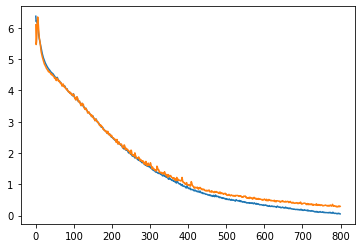

In [ ]:
plt.plot(np.log(train_losses))
plt.plot(np.log(val_losses))
plt.show()

In [ ]:
temp_trainSSIM = []
temp_trainPSNR = []
temp_valSSIM = []
temp_valPSNR = []


with torch.no_grad():
      use_cuda = torch.cuda.is_available()
      device = torch.device("cuda:0" if use_cuda else "cpu")
      torch.backends.cudnn.benchmark = True
      if use_cuda:
        if torch.cuda.device_count() > 1:
          print("Let's use", torch.cuda.device_count(), "GPUs!")
          # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
          PSOMVAE = nn.DataParallel(PSOMVAE) #NewVQVAE = nn.DataParallel(NewVQVAE)
      PSOMVAE.to(device)#NewVQVAE.to(device)
      PSOMVAE.eval()#NewVQVAE.eval()
      for Xin_train,Xout_train in train_dataloader:
          Xin_train,Xout_train = Xin_train.to(device), Xout_train.to(device)
          Xrecon_train = PSOMVAE(Xin_train)["x_out"]#NewVQVAE(Xin_train)["x_out_ze"]
          train_psnr_batch = PSNR(Xout_train,Xrecon_train)
          temp_trainPSNR.append(train_psnr_batch)
          #if epoch % 2 == 0:
          train_ssim_batch = SSIM(Xout_train,Xrecon_train)
          temp_trainSSIM.append(train_ssim_batch)

      
      for Xin_val,Xout_val in val_dataloader:
          Xin_val,Xout_val = Xin_val.to(device),Xout_val.to(device)
          Xrecon_val = PSOMVAE(Xin_val)["x_out"] #NewVQVAE(Xin_val)["x_out_ze"]
          val_psnr_batch = PSNR(Xout_val,Xrecon_val)
          temp_valPSNR.append(val_psnr_batch)
          #if epoch % 2 ==0:
          val_ssim_batch = SSIM(Xout_val,Xrecon_val)
          temp_valSSIM.append(val_ssim_batch)

In [ ]:
trainSSIM = torch.cat(temp_trainSSIM).mean()
print(trainSSIM)

valSSIM = torch.cat(temp_valSSIM).mean()
print(valSSIM)

trainPSNR = torch.cat(temp_trainPSNR).mean()
print(trainPSNR)

valPSNR = torch.cat(temp_valPSNR).mean()
print(valPSNR)

tensor(0.9050, device='cuda:0')
tensor(0.9050, device='cuda:0')
tensor(25.9287, device='cuda:0')
tensor(26.5178, device='cuda:0')


In [ ]:
torch.save({"epoch":epoch,"model_state_dict":PSOMVAE.state_dict(),"optimizer_state_dict": optimizer.state_dict(),"train_loss": train_losses,"val_loss":val_losses,"trainSSIM":trainSSIM,
            "valSSIM":valSSIM,"trainPSNR":trainPSNR,"valPSNR":valPSNR},
           "PSOMVAE32_256_4filters_800epochs_toroid_gamma10beta1_060121.tar")


In [ ]:

def MoranScore(SOMmodel):
    codebook = SOMmodel.quantization._embedding.weight.detach().cpu().numpy()
    som_h = SOMmodel.quantization._som_h
    som_w = SOMmodel.quantization._som_w
    idx_to_coord = SOMmodel.quantization.idx_to_coord

    N = codebook.shape[0]
    #codebook = SS.fit_transform(codebook)
    codebook = codebook.sum(axis=1,keepdims=True)
    #codebook = codebook[:,10].reshape(N,1)
    codebook_mean = codebook.mean(axis=0,keepdims=True)

    centered_codebook = codebook - codebook_mean

    XXT = np.matmul(centered_codebook,centered_codebook.T)

    W_ij = np.zeros(XXT.shape) #weight matrix

    for i in range(codebook.shape[0]):
        for j in range(codebook.shape[0]):
            hi,wi = idx_to_coord[i] #hi and wj here are coordinates of SOM grid
            hj,wj = idx_to_coord[j]
            som_dist = np.abs(hj-hi) + np.abs(wj-wi)
            W_ij[i,j] = np.exp(-som_dist)

    XXT_diag = np.diag(XXT)
    W = np.sum(W_ij)

    I_Moran = N/W * (np.sum(W_ij * XXT))/(np.sum(XXT_diag))

    return(I_Moran)

In [ ]:
codebook = PSOMVAE.quantization._embedding.weight.detach().cpu().numpy()
codebook_grid = codebook.reshape(16,16,-1)

In [ ]:
codebook_grid[5,5]

array([-0.3017994 ,  0.4913179 ,  0.19437163, -0.0272471 , -0.37041327,
       -0.2050403 ,  0.29521814,  0.4934549 , -0.2216039 ,  0.19432431,
       -0.13910775, -0.35834292, -0.15969953, -0.20641805,  0.00754393,
       -0.13867366,  0.25491464, -0.156002  ,  0.21382657, -0.04345706,
       -0.44390061, -0.26917362, -0.2814871 , -0.02842945,  0.39763963,
        0.3853565 , -0.16673574, -0.00073709, -0.2796924 , -0.262709  ,
        0.073173  , -0.39033148], dtype=float32)

In [ ]:
codebook_grid[1,6]

array([-0.5342682 ,  1.2838826 , -0.24977894, -0.8423915 , -1.223355  ,
       -0.02182214,  0.04549299,  1.8177997 , -0.31472522,  0.61766684,
       -0.9273695 , -0.88086426, -0.1788299 , -1.5579923 ,  0.40855548,
       -0.47606346,  0.85638165, -0.8672818 , -0.3101579 ,  0.4452789 ,
       -1.0647322 , -0.17063852, -1.9093276 , -0.57437277,  0.3544645 ,
        1.1621642 , -0.7386753 , -0.51412326, -0.0622881 , -0.60089016,
        4.2228513 , -0.6054748 ], dtype=float32)

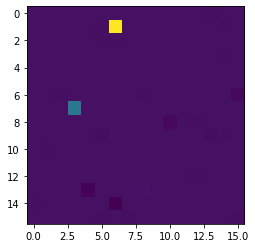

In [ ]:
plt.imshow(codebook_grid[:,:,14])
plt.show()

In [ ]:
MoranScore(PSOMVAE)

0.23705356043800707

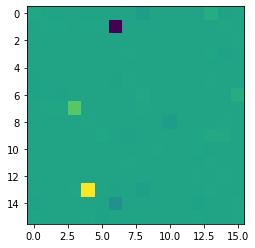

In [ ]:
plt.imshow(codebook.sum(axis=1).reshape(16,16))
plt.show()